# Student Performance Prediction

This notebook implements four machine learning algorithms to predict student exam scores based on various factors including study hours, attendance, parental involvement, and other academic indicators.

## Algorithms Used:
1. Linear Regression
2. Random Forest Regressor
3. Support Vector Regression (SVR)
4. Gradient Boosting Regressor

## Dataset Features:
- Hours_Studied, Attendance, Parental_Involvement, Access_to_Resources
- Extracurricular_Activities, Sleep_Hours, Previous_Scores, Motivation_Level
- Internet_Access, Tutoring_Sessions, Family_Income, Teacher_Quality
- School_Type, Peer_Influence, Physical_Activity, Learning_Disabilities
- Parental_Education_Level, Distance_from_Home, Gender
- **Target Variable**: Exam_Score

## 1. Import Required Libraries

In [151]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set pastel feminine color palette (only two pinks as requested)
feminine_colors = ['#FF69B4', '#DDA0DD', '#87CEEB', '#FFB6C1', '#E6E6FA', '#B19CD9']
plt.style.use('default')
sns.set_palette(feminine_colors)

## 2. Load and Explore the Dataset

In [152]:
# Load the dataset
df = pd.read_csv('StudentPerformanceFactors.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (6607, 20)

First 5 rows:
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_I

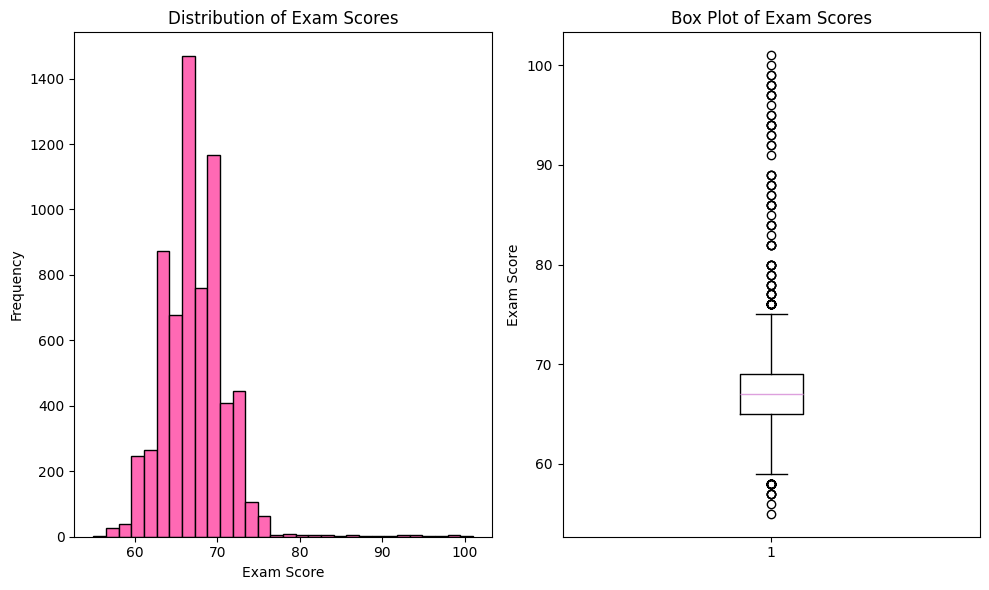

Exam Score Statistics:
Mean: 67.24
Median: 67.00
Standard Deviation: 3.89
Min: 55
Max: 101


In [153]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Exam_Score'], bins=30, edgecolor='black')
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['Exam_Score'])
plt.title('Box Plot of Exam Scores')
plt.ylabel('Exam Score')

plt.tight_layout()
plt.savefig('01_exam_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Exam Score Statistics:")
print(f"Mean: {df['Exam_Score'].mean():.2f}")
print(f"Median: {df['Exam_Score'].median():.2f}")
print(f"Standard Deviation: {df['Exam_Score'].std():.2f}")
print(f"Min: {df['Exam_Score'].min()}")
print(f"Max: {df['Exam_Score'].max()}")

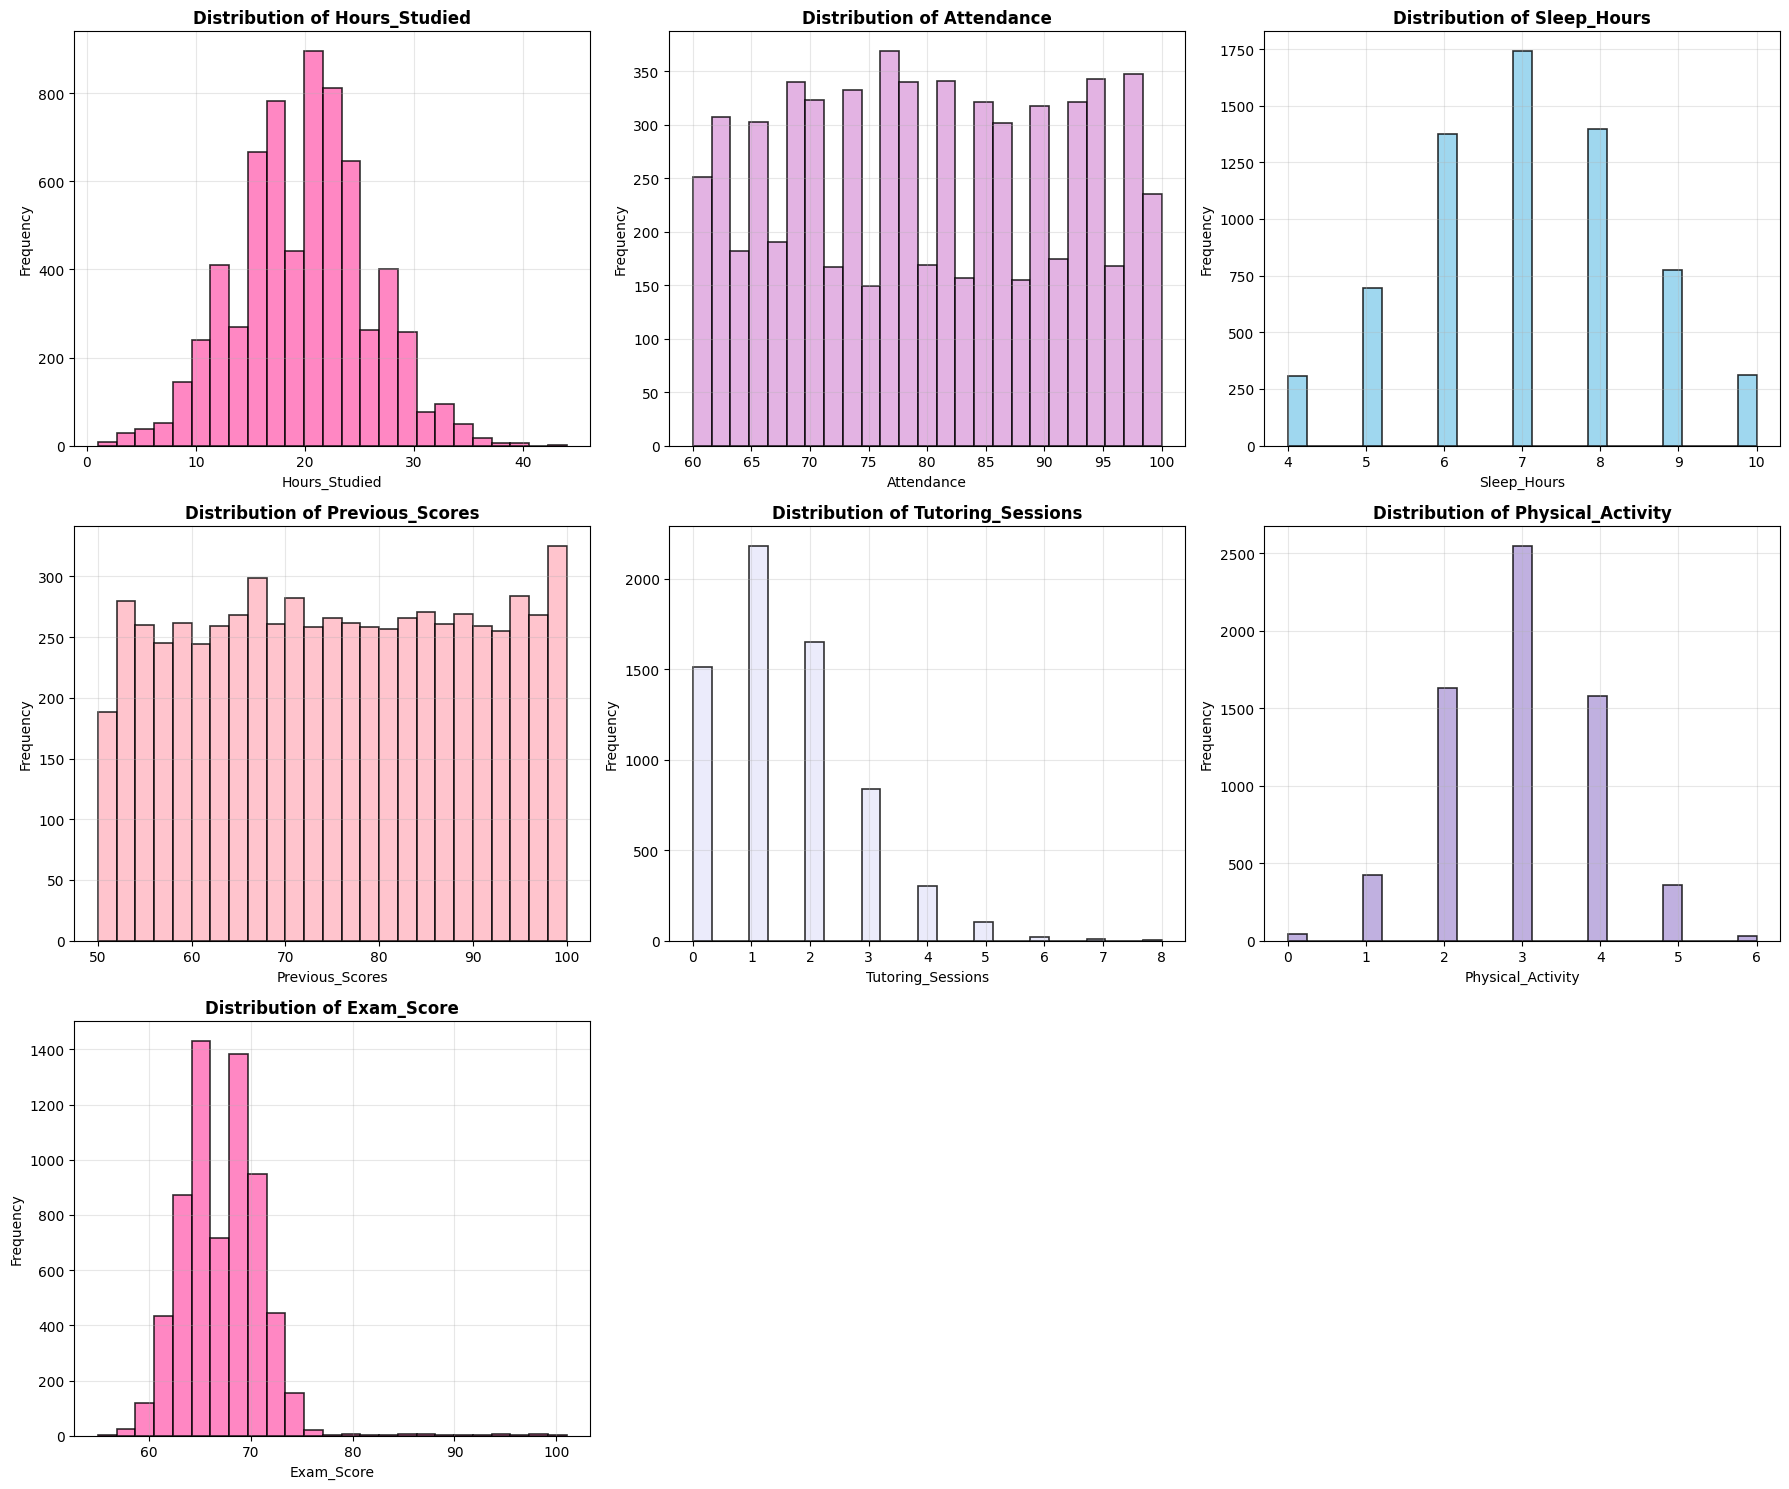

In [154]:
# Set pastel feminine color palette (only two pinks as requested)
feminine_colors = ['#FF69B4', '#DDA0DD', '#87CEEB', '#FFB6C1', '#E6E6FA', '#B19CD9']
sns.set_palette(feminine_colors)

# Exploratory Data Analysis - Numerical Variables
numerical_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 
                 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=25, color=feminine_colors[i % len(feminine_colors)], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# Hide the extra subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('02_numerical_variables_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

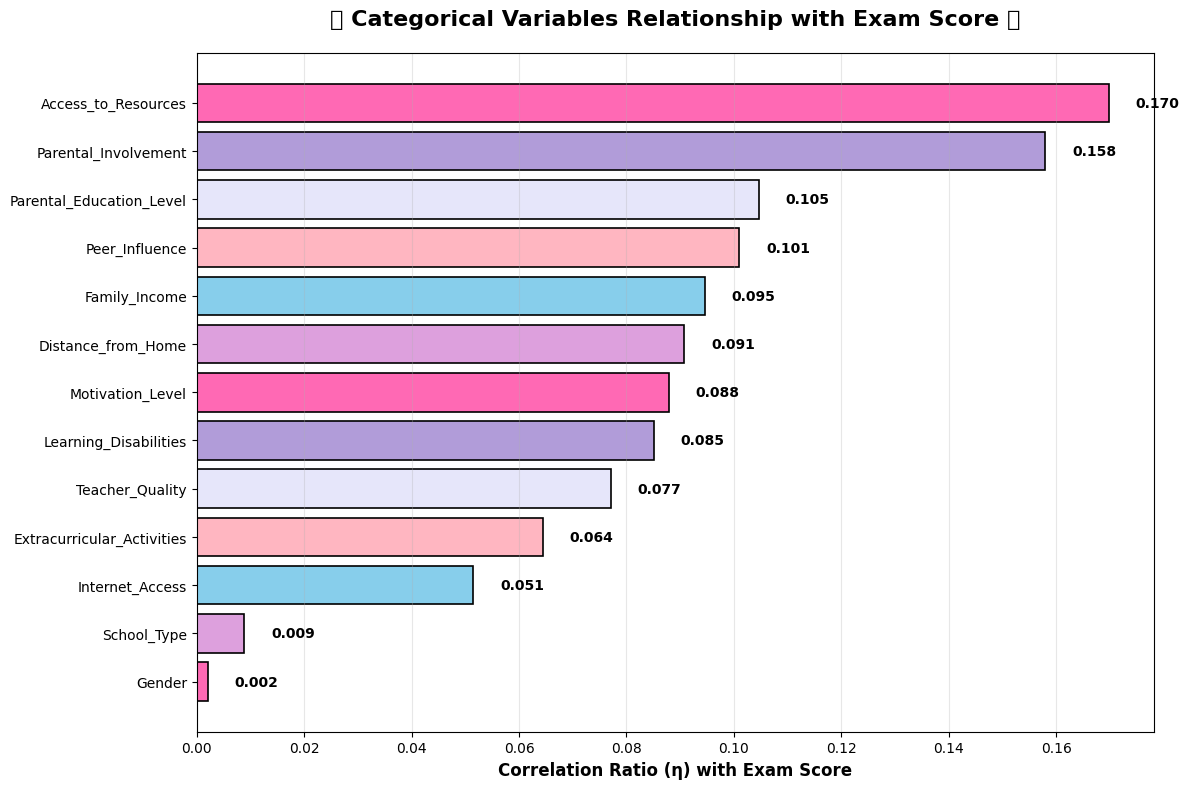

Correlation Ratio (η) ranges from 0 (no relationship) to 1 (perfect relationship)
Higher values indicate stronger relationship between categorical variable and Exam Score

Top 5 categorical variables most related to Exam Score:
    Categorical_Variable  Correlation_with_Exam_Score
           Family_Income                     0.094564
          Peer_Influence                     0.101031
Parental_Education_Level                     0.104663
    Parental_Involvement                     0.157951
     Access_to_Resources                     0.169779


In [155]:
# Define categorical columns (needed for correlation analysis)
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 
                      'Parental_Education_Level', 'Distance_from_Home', 'Gender']

categorical_cols = categorical_columns.copy()  # Alias for consistency

# Cramér's V calculation for categorical associations
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Import scipy.stats for chi2_contingency
from scipy import stats

# Create categorical association matrix using Cramér's V
categorical_association = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                                     index=categorical_columns, columns=categorical_columns)

for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i == j:
            categorical_association.loc[col1, col2] = 1.0
        elif i < j:
            cramers = cramers_v(df[col1], df[col2])
            categorical_association.loc[col1, col2] = cramers
            categorical_association.loc[col2, col1] = cramers

# Mixed Variables Correlation: Categorical vs Exam Score
# Calculate correlation ratio (eta) for categorical vs numerical
def correlation_ratio(categories, values):
    """Calculate correlation ratio (eta) between categorical and numerical variables."""
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(0, cat_num):
        cat_measures = values[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(values, y_total_avg), 2))
    
    if denominator == 0:
        return 0
    else:
        return np.sqrt(numerator / denominator)

# Calculate correlation ratio for each categorical variable with Exam_Score
cat_exam_correlations = {}
for col in categorical_columns:
    eta = correlation_ratio(df[col], df['Exam_Score'])
    cat_exam_correlations[col] = eta

# Create a beautiful visualization for categorical-exam score relationships
cat_corr_df = pd.DataFrame(list(cat_exam_correlations.items()), 
                          columns=['Categorical_Variable', 'Correlation_with_Exam_Score'])
cat_corr_df = cat_corr_df.sort_values('Correlation_with_Exam_Score', ascending=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(cat_corr_df['Categorical_Variable'], cat_corr_df['Correlation_with_Exam_Score'], 
               color=feminine_colors * 3, edgecolor='black', linewidth=1.2)

plt.xlabel('Correlation Ratio (η) with Exam Score', fontweight='bold', fontsize=12)
plt.title('🌸 Categorical Variables Relationship with Exam Score 🌸', 
          fontweight='bold', fontsize=16, pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('03_categorical_exam_score_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation Ratio (η) ranges from 0 (no relationship) to 1 (perfect relationship)")
print("Higher values indicate stronger relationship between categorical variable and Exam Score")
print("\nTop 5 categorical variables most related to Exam Score:")
print(cat_corr_df.tail().to_string(index=False))

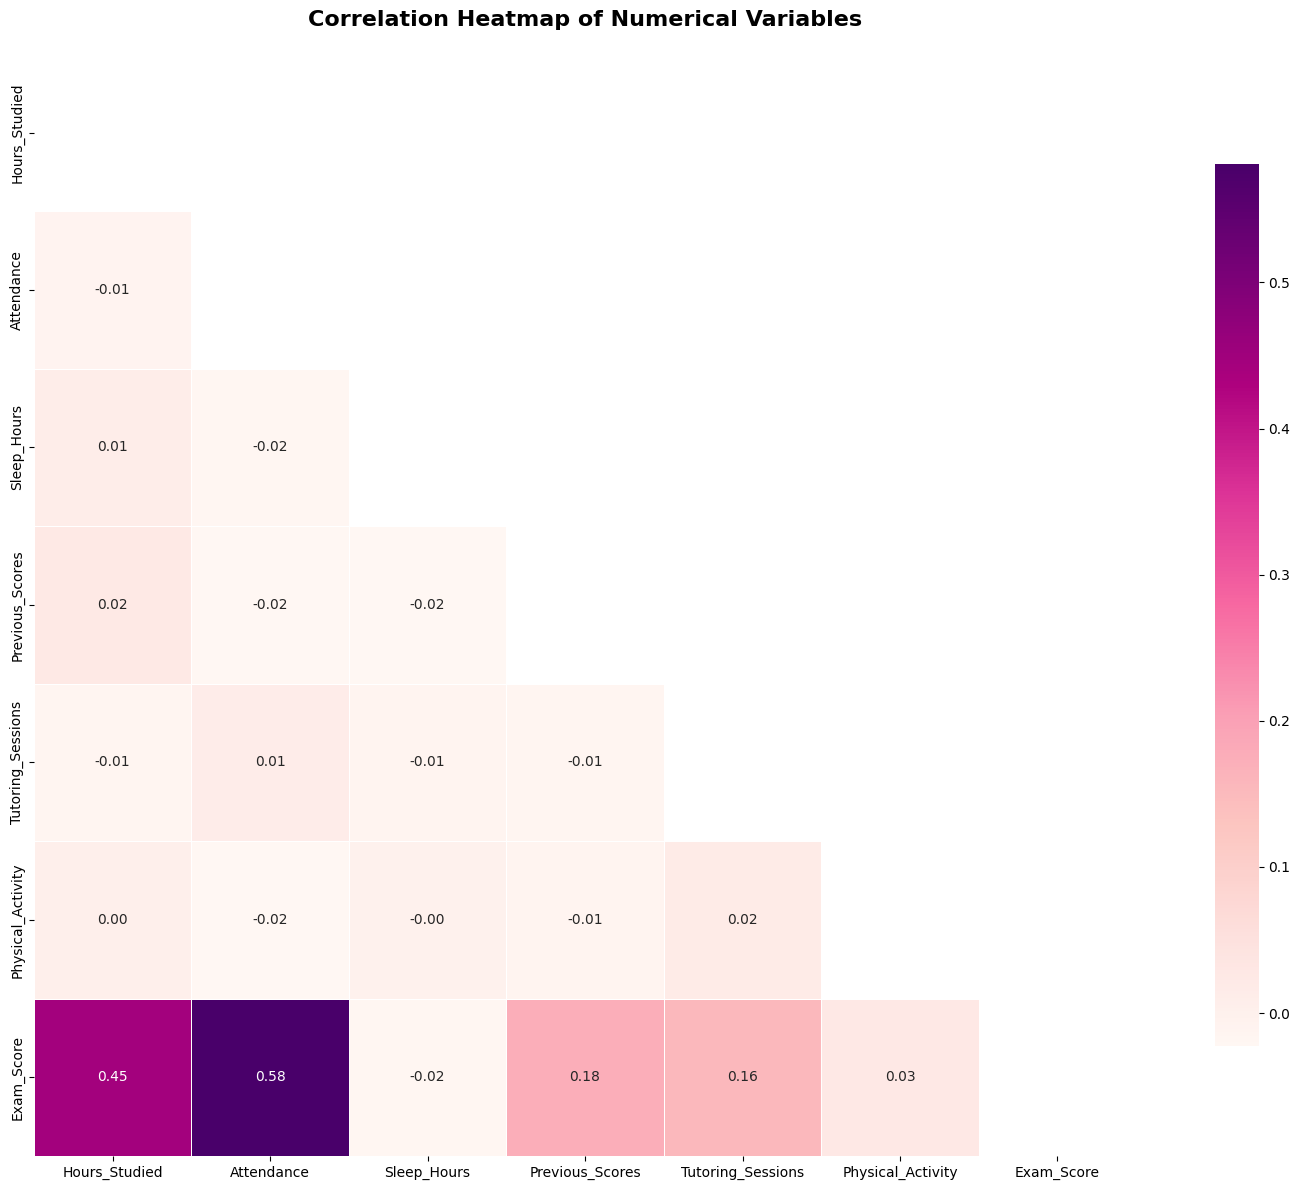

Strongest correlations with Exam Score:
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours          0.017022
Name: Exam_Score, dtype: float64


In [156]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))

# Calculate correlation matrix for numerical variables only
numerical_df = df[numerical_cols]
correlation_matrix = numerical_df.corr()

# Create heatmap with feminine colors
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdPu', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8},
            fmt='.2f', annot_kws={'size': 10})

plt.title('Correlation Heatmap of Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('04_numerical_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show strongest correlations with Exam_Score
exam_correlations = correlation_matrix['Exam_Score'].abs().sort_values(ascending=False)
print("Strongest correlations with Exam Score:")
print(exam_correlations[1:].head(10))  # Exclude self-correlation

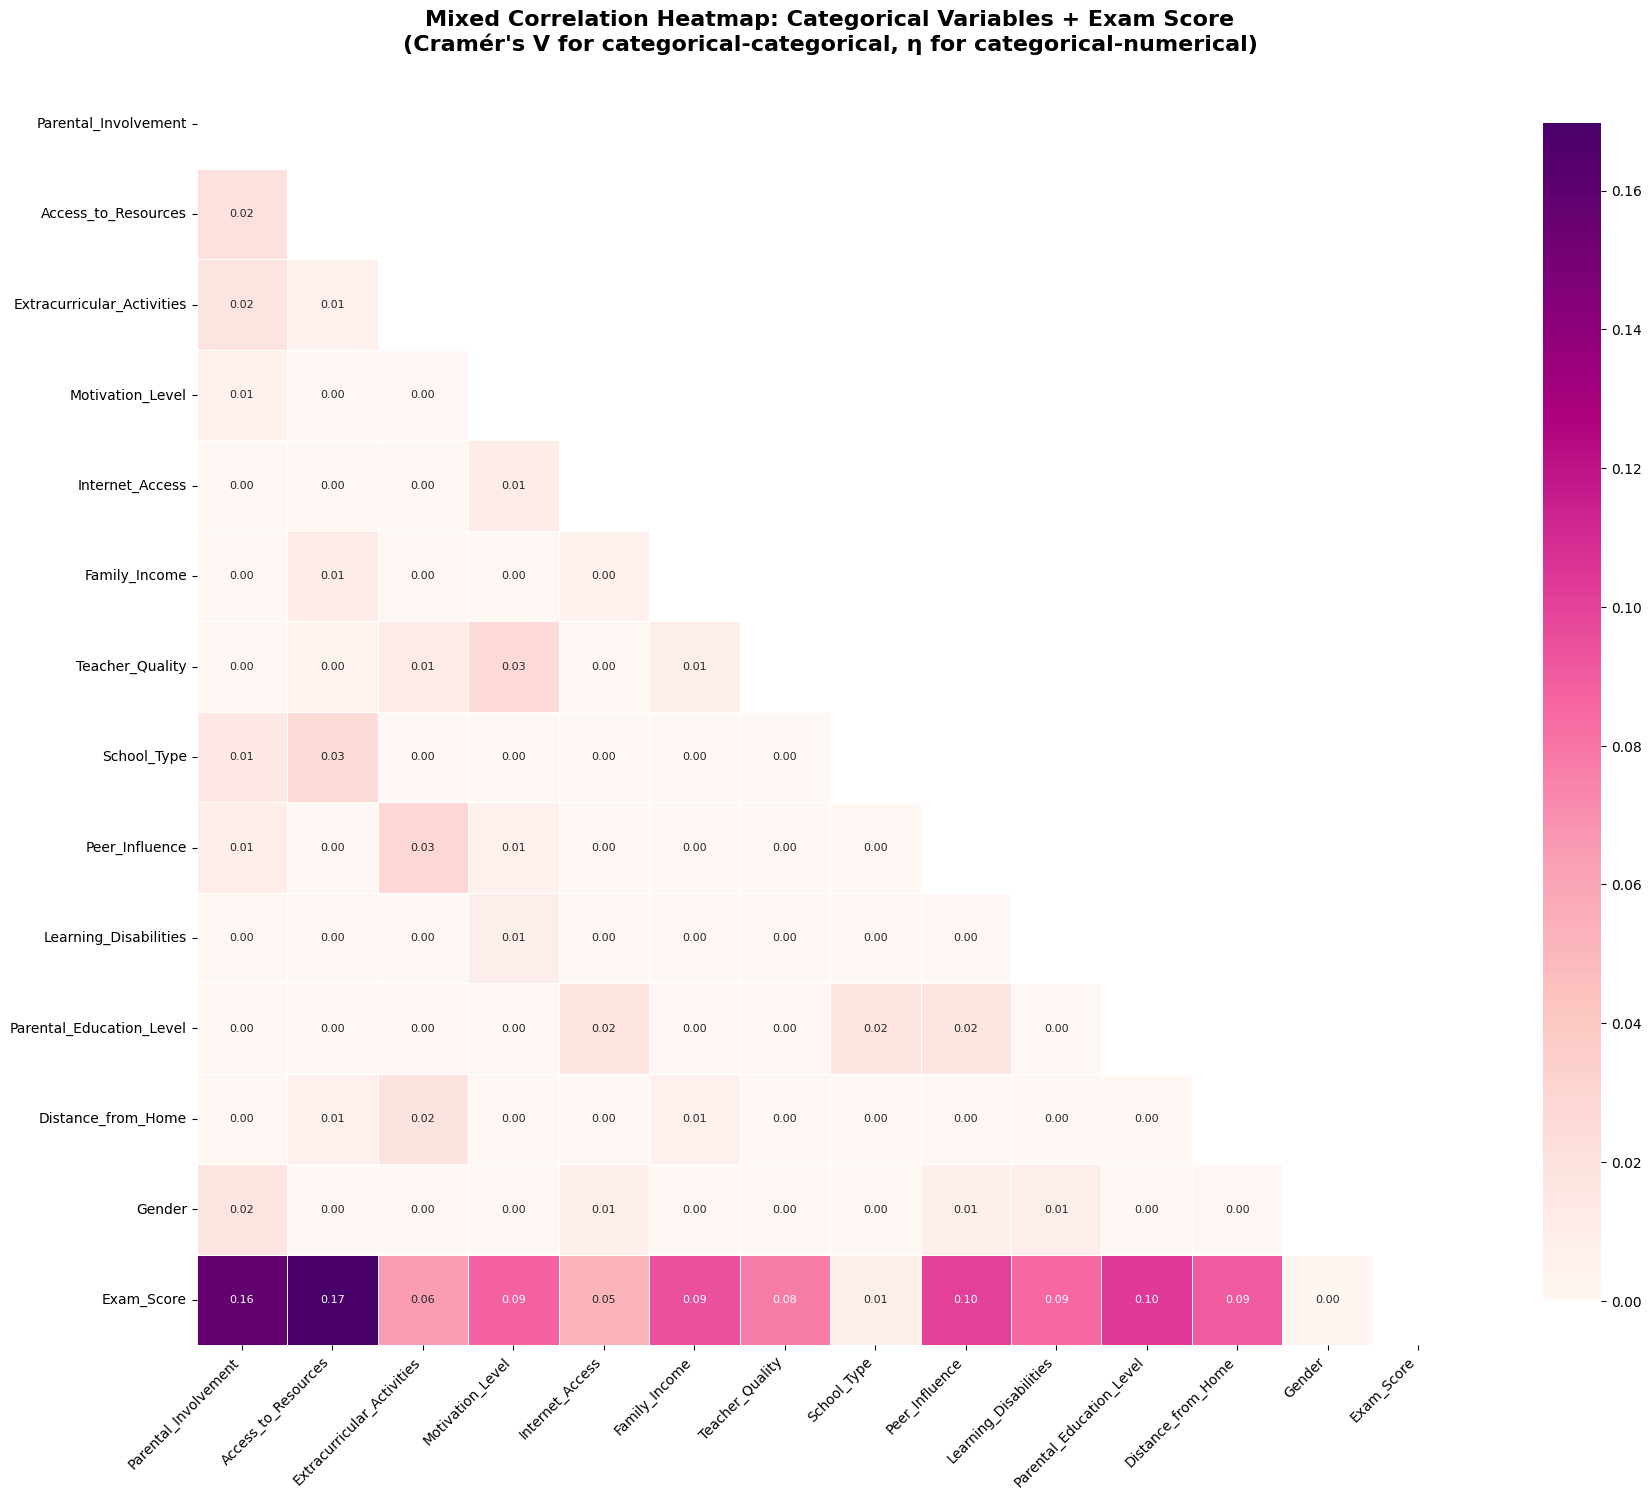

Mixed Correlation Matrix Legend:
• Cramér's V (categorical ↔ categorical): 0 = no association, 1 = perfect association
• Correlation Ratio η (categorical ↔ Exam_Score): 0 = no relationship, 1 = perfect relationship
• Values > 0.3 indicate moderate to strong relationships


In [157]:
# Create Mixed Correlation Matrix: Categorical Variables + Exam Score
# This combines Cramér's V (categorical-categorical) with Correlation Ratio (categorical-numerical)

# Start with the categorical association matrix
mixed_correlation = categorical_association.copy()

# Add Exam_Score as a new row and column
exam_score_col = 'Exam_Score'
mixed_correlation[exam_score_col] = 0.0
mixed_correlation.loc[exam_score_col] = 0.0

# Fill in the correlation ratios between categorical variables and Exam_Score
for col in categorical_cols:
    eta_value = cat_exam_correlations[col]
    mixed_correlation.loc[col, exam_score_col] = eta_value
    mixed_correlation.loc[exam_score_col, col] = eta_value

# Set Exam_Score self-correlation to 1
mixed_correlation.loc[exam_score_col, exam_score_col] = 1.0

# Create the mixed heatmap
plt.figure(figsize=(18, 16))
mask = np.triu(np.ones_like(mixed_correlation, dtype=bool))
sns.heatmap(mixed_correlation, mask=mask, annot=True, cmap='RdPu', 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8},
            fmt='.2f', annot_kws={'size': 8})

plt.title('Mixed Correlation Heatmap: Categorical Variables + Exam Score\n(Cramér\'s V for categorical-categorical, η for categorical-numerical)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('05_mixed_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Mixed Correlation Matrix Legend:")
print("• Cramér's V (categorical ↔ categorical): 0 = no association, 1 = perfect association")
print("• Correlation Ratio η (categorical ↔ Exam_Score): 0 = no relationship, 1 = perfect relationship")
print("• Values > 0.3 indicate moderate to strong relationships")

## 3. Data Preprocessing and Feature Engineering

In [158]:
# Create a copy for preprocessing
df_processed = df.copy()

# Identify categorical and numerical columns
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 
                      'Parental_Education_Level', 'Distance_from_Home', 'Gender']

numerical_columns = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                    'Tutoring_Sessions', 'Physical_Activity']

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

# Check unique values in categorical columns
for col in categorical_columns:
    print(f"\n{col}: {df_processed[col].unique()}")

Categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

Parental_Involvement: ['Low' 'Medium' 'High']

Access_to_Resources: ['High' 'Medium' 'Low']

Extracurricular_Activities: ['No' 'Yes']

Motivation_Level: ['Low' 'Medium' 'High']

Internet_Access: ['Yes' 'No']

Family_Income: ['Low' 'Medium' 'High']

Teacher_Quality: ['Medium' 'High' 'Low' nan]

School_Type: ['Public' 'Private']

Peer_Influence: ['Positive' 'Negative' 'Neutral']

Learning_Disabilities: ['No' 'Yes']

Parental_Education_Level: ['High School' 'College' 'Postgraduate' nan]

Distance_from_Home: ['Near' 'Moderate' 'Far' nan]

Gender: ['Male' 'Female']


In [159]:
# Label encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Separate features and target
X = df_processed.drop('Exam_Score', axis=1)
y = df_processed['Exam_Score']

# Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X[numerical_columns])

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nPreprocessed features preview:")
print(X_scaled.head())

Features shape: (6607, 19)
Target shape: (6607,)

Preprocessed features preview:
   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0       0.504942    0.348375                     1                    0   
1      -0.162822   -1.383736                     1                    2   
2       0.671882    1.560853                     2                    2   
3       1.506587    0.781403                     1                    2   
4      -0.162822    1.041220                     2                    2   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0    -0.019796        -0.143800                 1   
1                           0     0.661399        -1.116110                 1   
2                           1    -0.019796         1.106313                 2   
3                           1     0.661399         1.592469                 2   
4                           1    -0.700990        -0.699406    

## 4. Split Data into Training and Testing Sets

In [160]:
# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Create a dictionary to store model results
model_results = {}

Training set size: 5285 samples
Testing set size: 1322 samples
Features: 19


## 5. Linear Regression Model

Linear Regression Results:
RMSE: 2.098
MAE: 1.016
R² Score: 0.689
Accuracy (±2 points): 92.1%


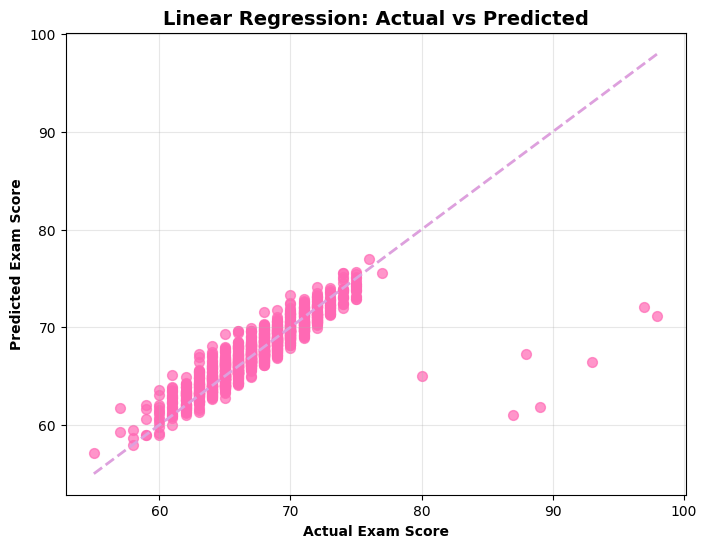

In [161]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Calculate metrics
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

# Calculate accuracy (within 5 points tolerance)
lr_accuracy = np.mean(np.abs(y_test - lr_pred) <= 2) * 100

# Store results
model_results['Linear Regression'] = {
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2,
    'Accuracy': lr_accuracy,
    'Predictions': lr_pred
}

print("Linear Regression Results:")
print(f"RMSE: {lr_rmse:.3f}")
print(f"MAE: {lr_mae:.3f}")
print(f"R² Score: {lr_r2:.3f}")
print(f"Accuracy (±2 points): {lr_accuracy:.1f}%")

# Plot predictions vs actual with feminine colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, alpha=0.7, color='#FF69B4', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('Linear Regression: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('06_linear_regression_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Random Forest Regressor Model

Random Forest Results:
RMSE: 2.203
MAE: 1.126
R² Score: 0.657
Accuracy (±2 points): 88.5%


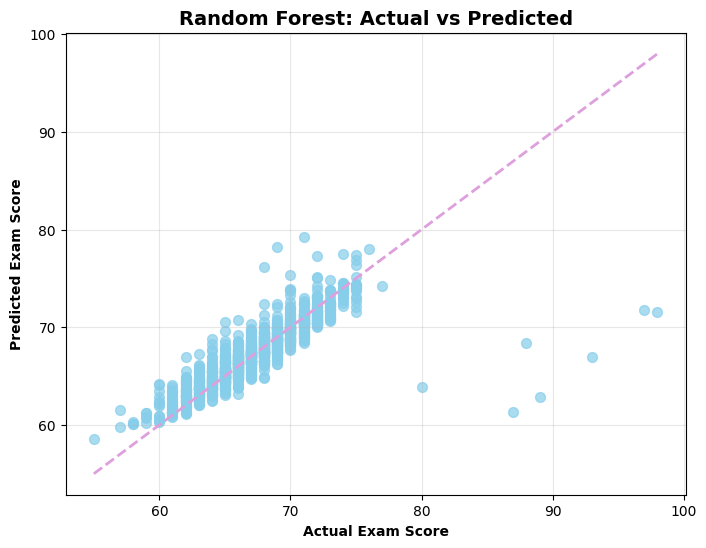

In [162]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Calculate metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# Calculate accuracy (within 5 points tolerance)
rf_accuracy = np.mean(np.abs(y_test - rf_pred) <= 2) * 100

# Store results
model_results['Random Forest'] = {
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'R²': rf_r2,
    'Accuracy': rf_accuracy,
    'Predictions': rf_pred
}

print("Random Forest Results:")
print(f"RMSE: {rf_rmse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"R² Score: {rf_r2:.3f}")
print(f"Accuracy (±2 points): {rf_accuracy:.1f}%")

# Plot predictions vs actual with feminine colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.7, color='#87CEEB', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('Random Forest: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('07_random_forest_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Support Vector Regression Model

Support Vector Regression Results:
RMSE: 1.843
MAE: 0.560
R² Score: 0.760
Accuracy (±2 points): 99.1%


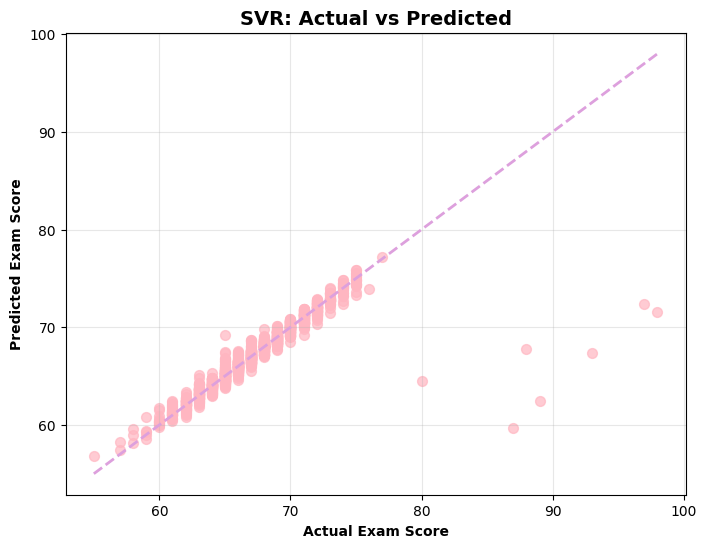

In [163]:
# Train Support Vector Regression model
svr_model = SVR(kernel='rbf', C=100, gamma='scale')
svr_model.fit(X_train, y_train)

# Make predictions
svr_pred = svr_model.predict(X_test)

# Calculate metrics
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

# Calculate accuracy (within 5 points tolerance)
svr_accuracy = np.mean(np.abs(y_test - svr_pred) <= 2) * 100

# Store results
model_results['SVR'] = {
    'RMSE': svr_rmse,
    'MAE': svr_mae,
    'R²': svr_r2,
    'Accuracy': svr_accuracy,
    'Predictions': svr_pred
}

print("Support Vector Regression Results:")
print(f"RMSE: {svr_rmse:.3f}")
print(f"MAE: {svr_mae:.3f}")
print(f"R² Score: {svr_r2:.3f}")
print(f"Accuracy (±2 points): {svr_accuracy:.1f}%")

# Plot predictions vs actual with feminine colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_pred, alpha=0.7, color='#FFB6C1', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('SVR: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('08_svr_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Gradient Boosting Regressor Model

Gradient Boosting Results:
RMSE: 1.949
MAE: 0.824
R² Score: 0.731
Accuracy (±2 points): 95.8%


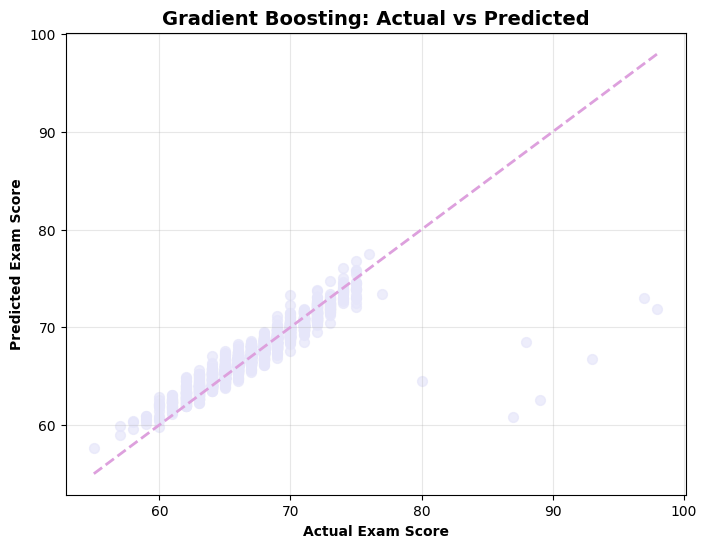

In [164]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test)

# Calculate metrics
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

# Calculate accuracy (within 5 points tolerance)
gb_accuracy = np.mean(np.abs(y_test - gb_pred) <= 2) * 100

# Store results
model_results['Gradient Boosting'] = {
    'RMSE': gb_rmse,
    'MAE': gb_mae,
    'R²': gb_r2,
    'Accuracy': gb_accuracy,
    'Predictions': gb_pred
}

print("Gradient Boosting Results:")
print(f"RMSE: {gb_rmse:.3f}")
print(f"MAE: {gb_mae:.3f}")
print(f"R² Score: {gb_r2:.3f}")
print(f"Accuracy (±2 points): {gb_accuracy:.1f}%")

# Plot predictions vs actual with feminine colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gb_pred, alpha=0.7, color='#E6E6FA', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('Gradient Boosting: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('09_gradient_boosting_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Model Comparison and Evaluation

Model Comparison:
               Model   RMSE    MAE     R²  Accuracy (%)
2                SVR  1.843  0.560  0.760        99.092
3  Gradient Boosting  1.949  0.824  0.731        95.764
0  Linear Regression  2.098  1.016  0.689        92.057
1      Random Forest  2.203  1.126  0.657        88.502


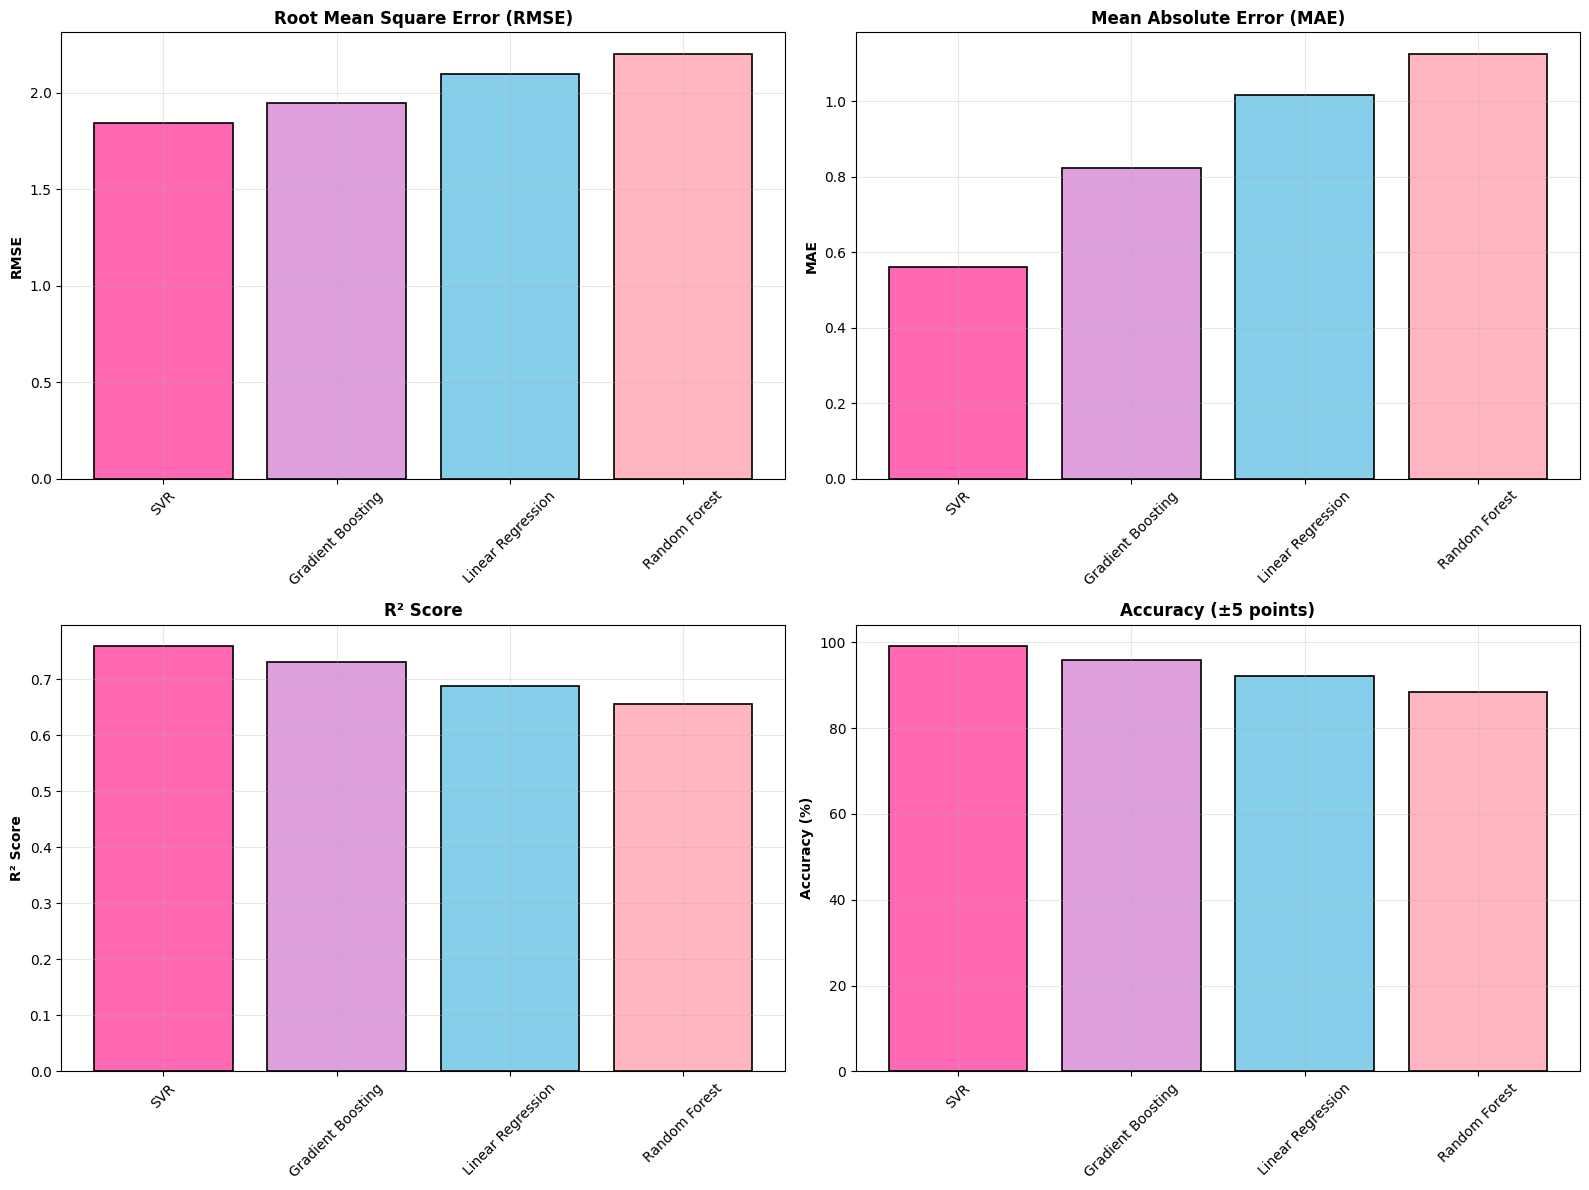

Accuracy: 99.1%

Best performing model: SVR
R² Score: 0.760


In [165]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [model_results[model]['RMSE'] for model in model_results.keys()],
    'MAE': [model_results[model]['MAE'] for model in model_results.keys()],
    'R²': [model_results[model]['R²'] for model in model_results.keys()],
    'Accuracy (%)': [model_results[model]['Accuracy'] for model in model_results.keys()]
})

# Sort by R² score (descending)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("Model Comparison:")
print(comparison_df.round(3))

# Visualize model comparison with pastel feminine colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['RMSE'], color=feminine_colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[0,0].set_title('Root Mean Square Error (RMSE)', fontweight='bold', fontsize=12)
axes[0,0].set_ylabel('RMSE', fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# MAE comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['MAE'], color=feminine_colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[0,1].set_title('Mean Absolute Error (MAE)', fontweight='bold', fontsize=12)
axes[0,1].set_ylabel('MAE', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# R² comparison
axes[1,0].bar(comparison_df['Model'], comparison_df['R²'], color=feminine_colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[1,0].set_title('R² Score', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('R² Score', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['Accuracy (%)'], color=feminine_colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[1,1].set_title('Accuracy (±5 points)', fontweight='bold', fontsize=12)
axes[1,1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('10_model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model = comparison_df.iloc[0]['Model']
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy (%)']:.1f}%")

print(f"\nBest performing model: {best_model}")
print(f"R² Score: {comparison_df.iloc[0]['R²']:.3f}")

## 10. Feature Importance Analysis

Random Forest Feature Importance:
                 Feature  Importance
1             Attendance    0.381449
0          Hours_Studied    0.242662
6        Previous_Scores    0.091385
9      Tutoring_Sessions    0.035440
3    Access_to_Resources    0.028868
5            Sleep_Hours    0.028611
14     Physical_Activity    0.028010
2   Parental_Involvement    0.026583
10         Family_Income    0.019824
13        Peer_Influence    0.018788

Gradient Boosting Feature Importance:
                     Feature  Importance
1                 Attendance    0.466821
0              Hours_Studied    0.284031
6            Previous_Scores    0.050061
3        Access_to_Resources    0.039368
2       Parental_Involvement    0.038202
9          Tutoring_Sessions    0.036430
13            Peer_Influence    0.013550
10             Family_Income    0.012589
16  Parental_Education_Level    0.009252
7           Motivation_Level    0.008658


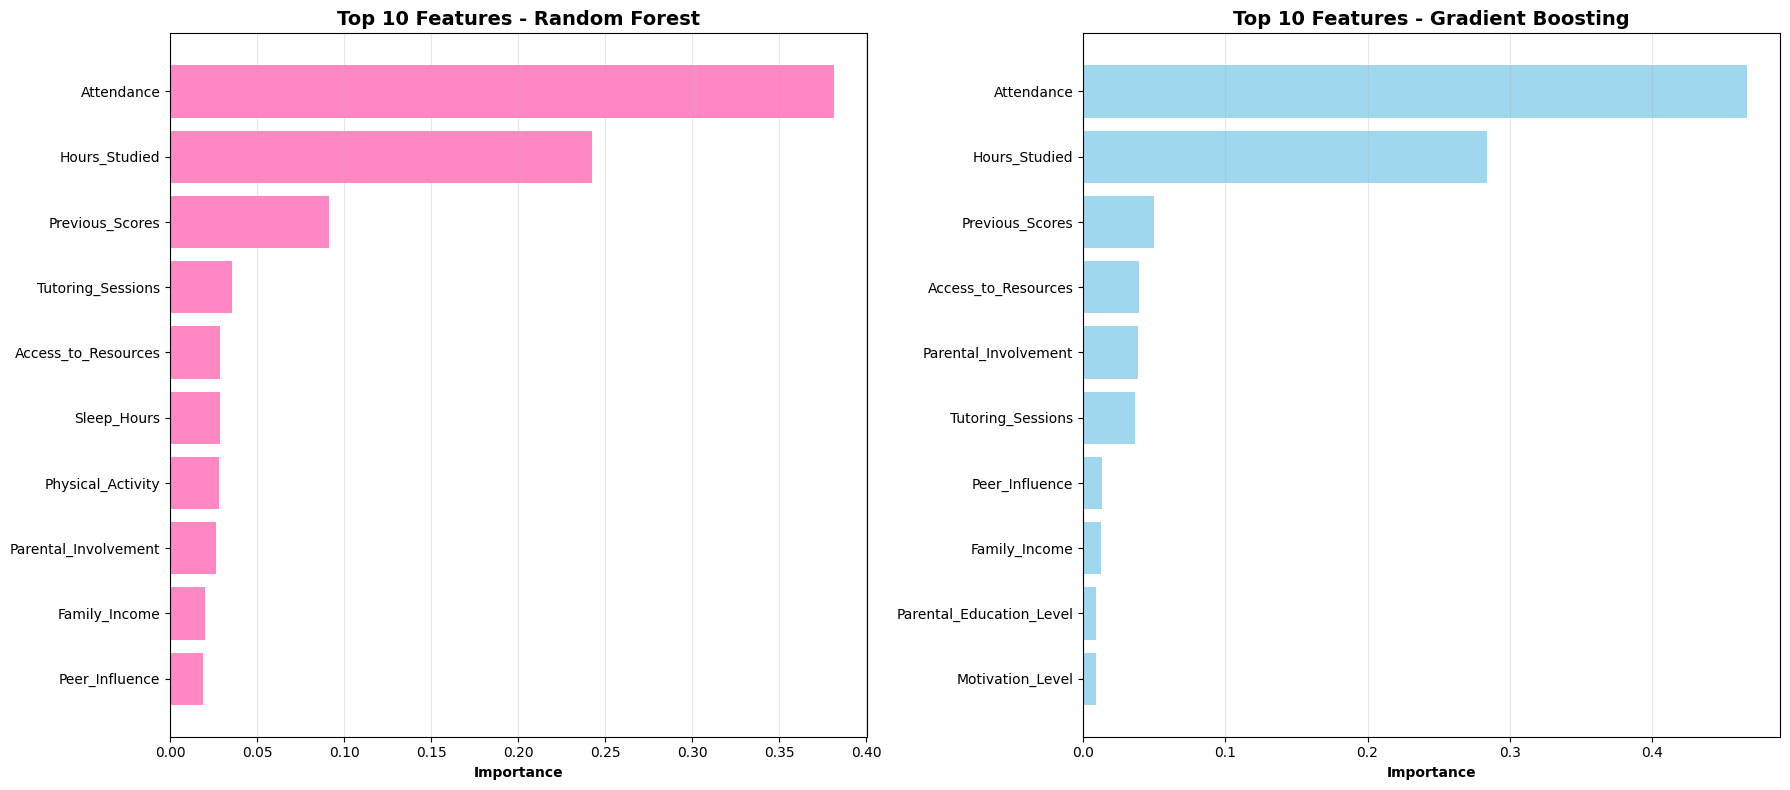

In [166]:
# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print(feature_importance_rf.head(10))

# Feature importance from Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nGradient Boosting Feature Importance:")
print(feature_importance_gb.head(10))

# Plot feature importance with feminine colors
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
bars1 = axes[0].barh(feature_importance_rf.head(10)['Feature'][::-1], 
                     feature_importance_rf.head(10)['Importance'][::-1],
                     color='#FF69B4', alpha=0.8)
axes[0].set_title('Top 10 Features - Random Forest', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Gradient Boosting
bars2 = axes[1].barh(feature_importance_gb.head(10)['Feature'][::-1], 
                     feature_importance_gb.head(10)['Importance'][::-1],
                     color='#87CEEB', alpha=0.8)
axes[1].set_title('Top 10 Features - Gradient Boosting', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Importance', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('11_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

This notebook demonstrated the implementation of four different machine learning algorithms to predict student exam scores:

1. **Linear Regression**: Simple baseline model
2. **Random Forest Regressor**: Ensemble method with good performance
3. **Support Vector Regression**: Non-linear regression with RBF kernel
4. **Gradient Boosting Regressor**: Sequential ensemble method

## 📊 Final Model Performance Summary

🌸 FINAL MODEL ACCURACY SUMMARY 🌸
Model Name           R² Score     RMSE       MAE        Accuracy    
SVR                  0.76         1.843      0.56       99.1%
Gradient Boosting    0.731        1.949      0.824      95.8%
Linear Regression    0.689        2.098      1.016      92.1%
Random Forest        0.657        2.203      1.126      88.5%
🏆 WINNER: SVR with 0.760 R² Score
💖 Best Accuracy: 99.1% (predictions within ±2 points)


<Figure size 1200x800 with 0 Axes>

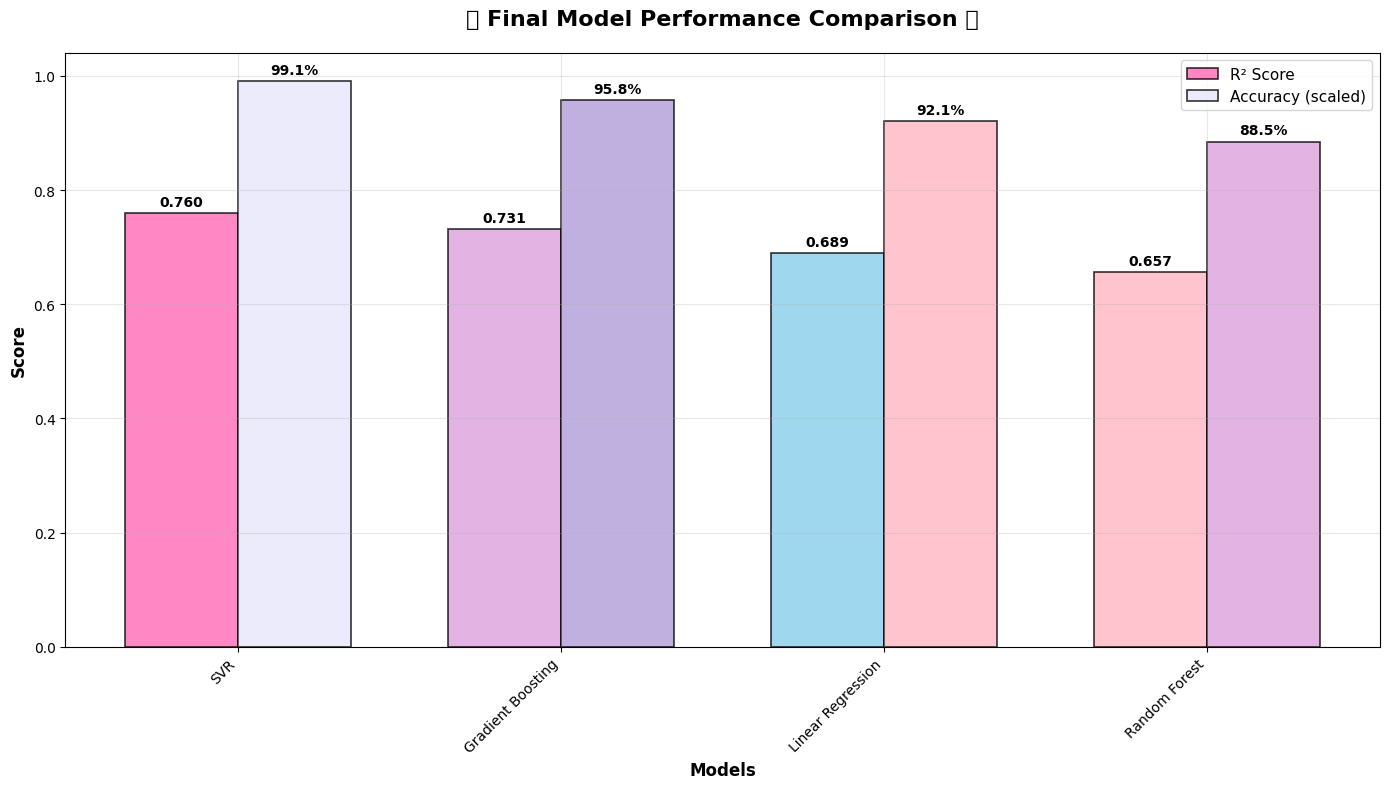

In [169]:
# Create a beautiful summary table
summary_df = comparison_df.copy()
summary_df = summary_df.round(3)

print("🌸 FINAL MODEL ACCURACY SUMMARY 🌸")
print("=" * 60)
print(f"{'Model Name':<20} {'R² Score':<12} {'RMSE':<10} {'MAE':<10} {'Accuracy':<12}")
print("=" * 60)

for idx, row in summary_df.iterrows():
    print(f"{row['Model']:<20} {row['R²']:<12} {row['RMSE']:<10} {row['MAE']:<10} {row['Accuracy (%)']:.1f}%")

print("=" * 60)
print(f"🏆 WINNER: {summary_df.iloc[0]['Model']} with {summary_df.iloc[0]['R²']:.3f} R² Score")
print(f"💖 Best Accuracy: {summary_df.iloc[0]['Accuracy (%)']:.1f}% (predictions within ±2 points)")

# Create a beautiful final visualization
plt.figure(figsize=(12, 8))

# Create a radar-like comparison (using R² and Accuracy)
models = summary_df['Model'].values
r2_scores = summary_df['R²'].values
accuracies = summary_df['Accuracy (%)'].values

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))

# Create bars with pastel feminine colors and black edges
bars1 = ax.bar(x - width/2, r2_scores, width, label='R² Score', 
               color=['#FF69B4', '#DDA0DD', '#87CEEB', '#FFB6C1'], alpha=0.8,
               edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, accuracies/100, width, label='Accuracy (scaled)', 
               color=['#E6E6FA', '#B19CD9', '#FFB6C1', '#DDA0DD'], alpha=0.8,
               edgecolor='black', linewidth=1.2)

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('🌸 Final Model Performance Comparison 🌸', fontweight='bold', fontsize=16, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

for bar, acc in zip(bars2, accuracies):
    height = bar.get_height()
    ax.annotate(f'{acc:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('12_final_model_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()